In [189]:
import pints
import numpy as np
import math
from scipy.constants import N_A
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve, brentq
import pandas as pd

In [216]:
Target_cell_number = 2e4
well_size = 50e-6
sigma = well_size*N_A/Target_cell_number
tumour_cell_radius = 7.25e-6
rtot1 = 4341 
t_end = 60*60*1
t = np.geomspace(1e-10, t_end, 50)
tspan = [1e-10, t_end]

In [191]:
df = pd.read_excel(r'/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/Data/RE_ Mono vs Bivalent cell binding data - high affinity Ab/ELN340091_Tabular.xlsx')
df = df.dropna(subset=['CELL_ID']).reset_index(drop=True)

def data_extractor(df, cell_id, antibody_id):

    detect_id = 'RL-2'
    df1 = df.query('CELL_ID==@cell_id & ANTIBODY_ID==@antibody_id & DETECTOR==@detect_id')
    mono_df = df1.query('ANTIBODY_FORMAT=="MONOVALENT"')
    biv_df = df1.query('ANTIBODY_FORMAT=="BIVALENT"')

    concs = list(np.flip(mono_df['ANTIBODY_CONCENTRATION_MOLAR'].values))
    response_mono = list(np.flip(mono_df['RESPONSE'].values))
    response_biv = list(np.flip(biv_df['RESPONSE'].values))
    
    return response_mono, response_biv, concs

In [192]:
mono, biv, conc = data_extractor(df, '500G_F', 28008.0)
mono = np.array(mono[:-1])
biv = np.array(biv[:-1])
conc = np.array(conc[:-1])
data = np.stack((mono, biv), axis=1)
data = data/rtot1

In [218]:
def model_eqns(t, z, kon, KD, k2, rtot, Ainit):
    Atot = Ainit*sigma
    k1 = kon/sigma
    A0 = Atot - z[0] - z[1]
    r = rtot - z[0] - 2*z[1]

    dA1 = 2*k1*r*A0 - (KD*kon)*z[0] - k2*r*z[0] + 2*(KD*kon)*z[1]
    dA2 = k2*z[0]*r - 2*(KD*kon)*z[1]

    return [dA1, dA2]


def solve_model_individual(kon, KD, k2, rtot, A0s):
    solution = np.zeros_like(A0s)
    z0 = [0, 0]
    for i, Ainit in enumerate(A0s):
        z = solve_ivp(model_eqns, tspan, z0, method='Radau', t_eval=t, args=(kon, KD, k2, rtot, Ainit))
        A1 = z.y[0]
        A2 = z.y[1]
        bound_ab = A1[-1] + A2[-1]
        solution[i] = bound_ab
    print(solution)
    return solution

def simulate_model(A0s, parameters):

    kon = parameters[0]
    kon = 10**kon
    KD = parameters[1]
    KD = 10**KD
    k2 = parameters[2]
    k2 = 10**k2
    #rtot = parameters[3]
    #rtot = 10**rtot
    rtot = rtot1
    C = parameters[3]
    C=10**C
    b = parameters[4]
    b = 10**b
    solution = np.zeros((len(A0s), 2))
    solution[:, 0] = (solve_model_individual(kon, KD, 0, rtot, A0s))
    solution[:, 1] = (solve_model_individual(kon, KD, k2, rtot, A0s))

    return (C*solution + b)


class model(pints.ForwardModel):

    def n_outputs(self):
         return 2
    
    def n_parameters(self):
        return 5
    
    def simulate(self, parameters, A0s):
        return simulate_model(A0s, parameters)

In [194]:
mod = model()
problem = pints.MultiOutputProblem(mod, conc, data)
log_likelihood = pints.GaussianLogLikelihood(problem)
parameters = [5.8, -8, -4,  1,  3, 0, 0.2, 0.2]
log_prior = pints.UniformLogPrior(
    [4, -12, -8, -1, 2, -2, 0.01, 0.01],
    [7,  -6, -1, 2, 4, 2, 1, 1]
)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

In [195]:
xs = [
    np.array(parameters) * 0.85,
    np.array(parameters) * 0.95,
    np.array(parameters) * 1.05,
    np.array(parameters) * 1.15 
]

In [196]:
mcmc = pints.MCMCController(log_posterior, 4, xs)
mcmc.set_max_iterations(10000)
chains = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.3
1     8      0.5       0         0.5       0.5        0:00.6
2     12     0.333     0         0.333     0.333      0:00.9
3     16     0.25      0         0.25      0.5        0:01.2
20    84     0.238     0.333     0.381     0.429      0:05.5
40    164    0.244     0.268     0.366     0.439      0:09.9
60    244    0.262     0.213     0.279     0.361      0:13.8
80    324    0.235     0.173     0.222     0.308642   0:18.3
100   404    0.287     0.178     0.208     0.257      0:22.8
120   484    0.281     0.165     0.182     0.214876   0:27.1
140   564    0.305     0.156     0.191     0.199      0:32.0
160   644    0.304     0.143     0.193     0.173913   0:37.0
180   724    0.287     0.133     0.198895  0.160221   0:42.2
Initial phase completed.
200   804    0.278607  0.

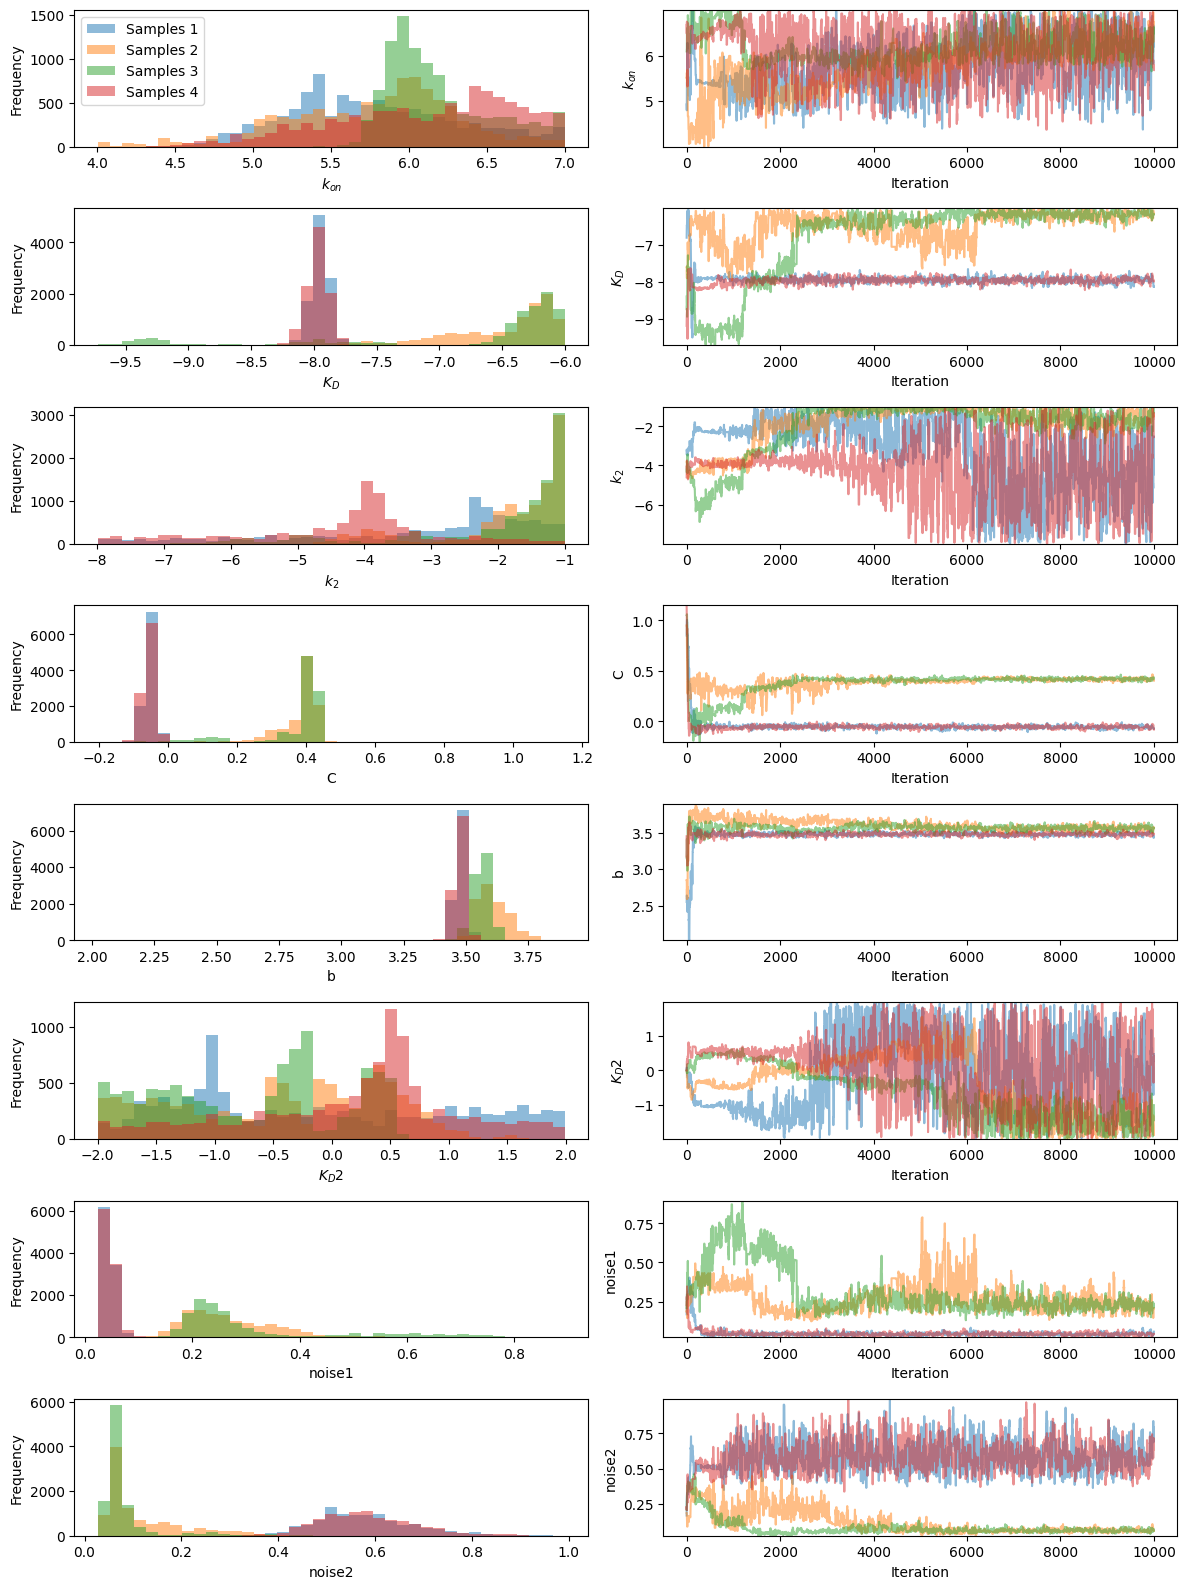

In [204]:
import pints.plot
#parameter_names=[r'$k_{on}$', r'$K_D$', r'$k_2$', r'$r_{tot}$', 'C', 'noise1', 'noise2']
parameter_names=[r'$k_{on}$', r'$K_D$', r'$k_2$', 'C', 'b', r'$K_D2$', 'noise1', 'noise2']
pints.plot.trace(chains, parameter_names=parameter_names)
plt.show()

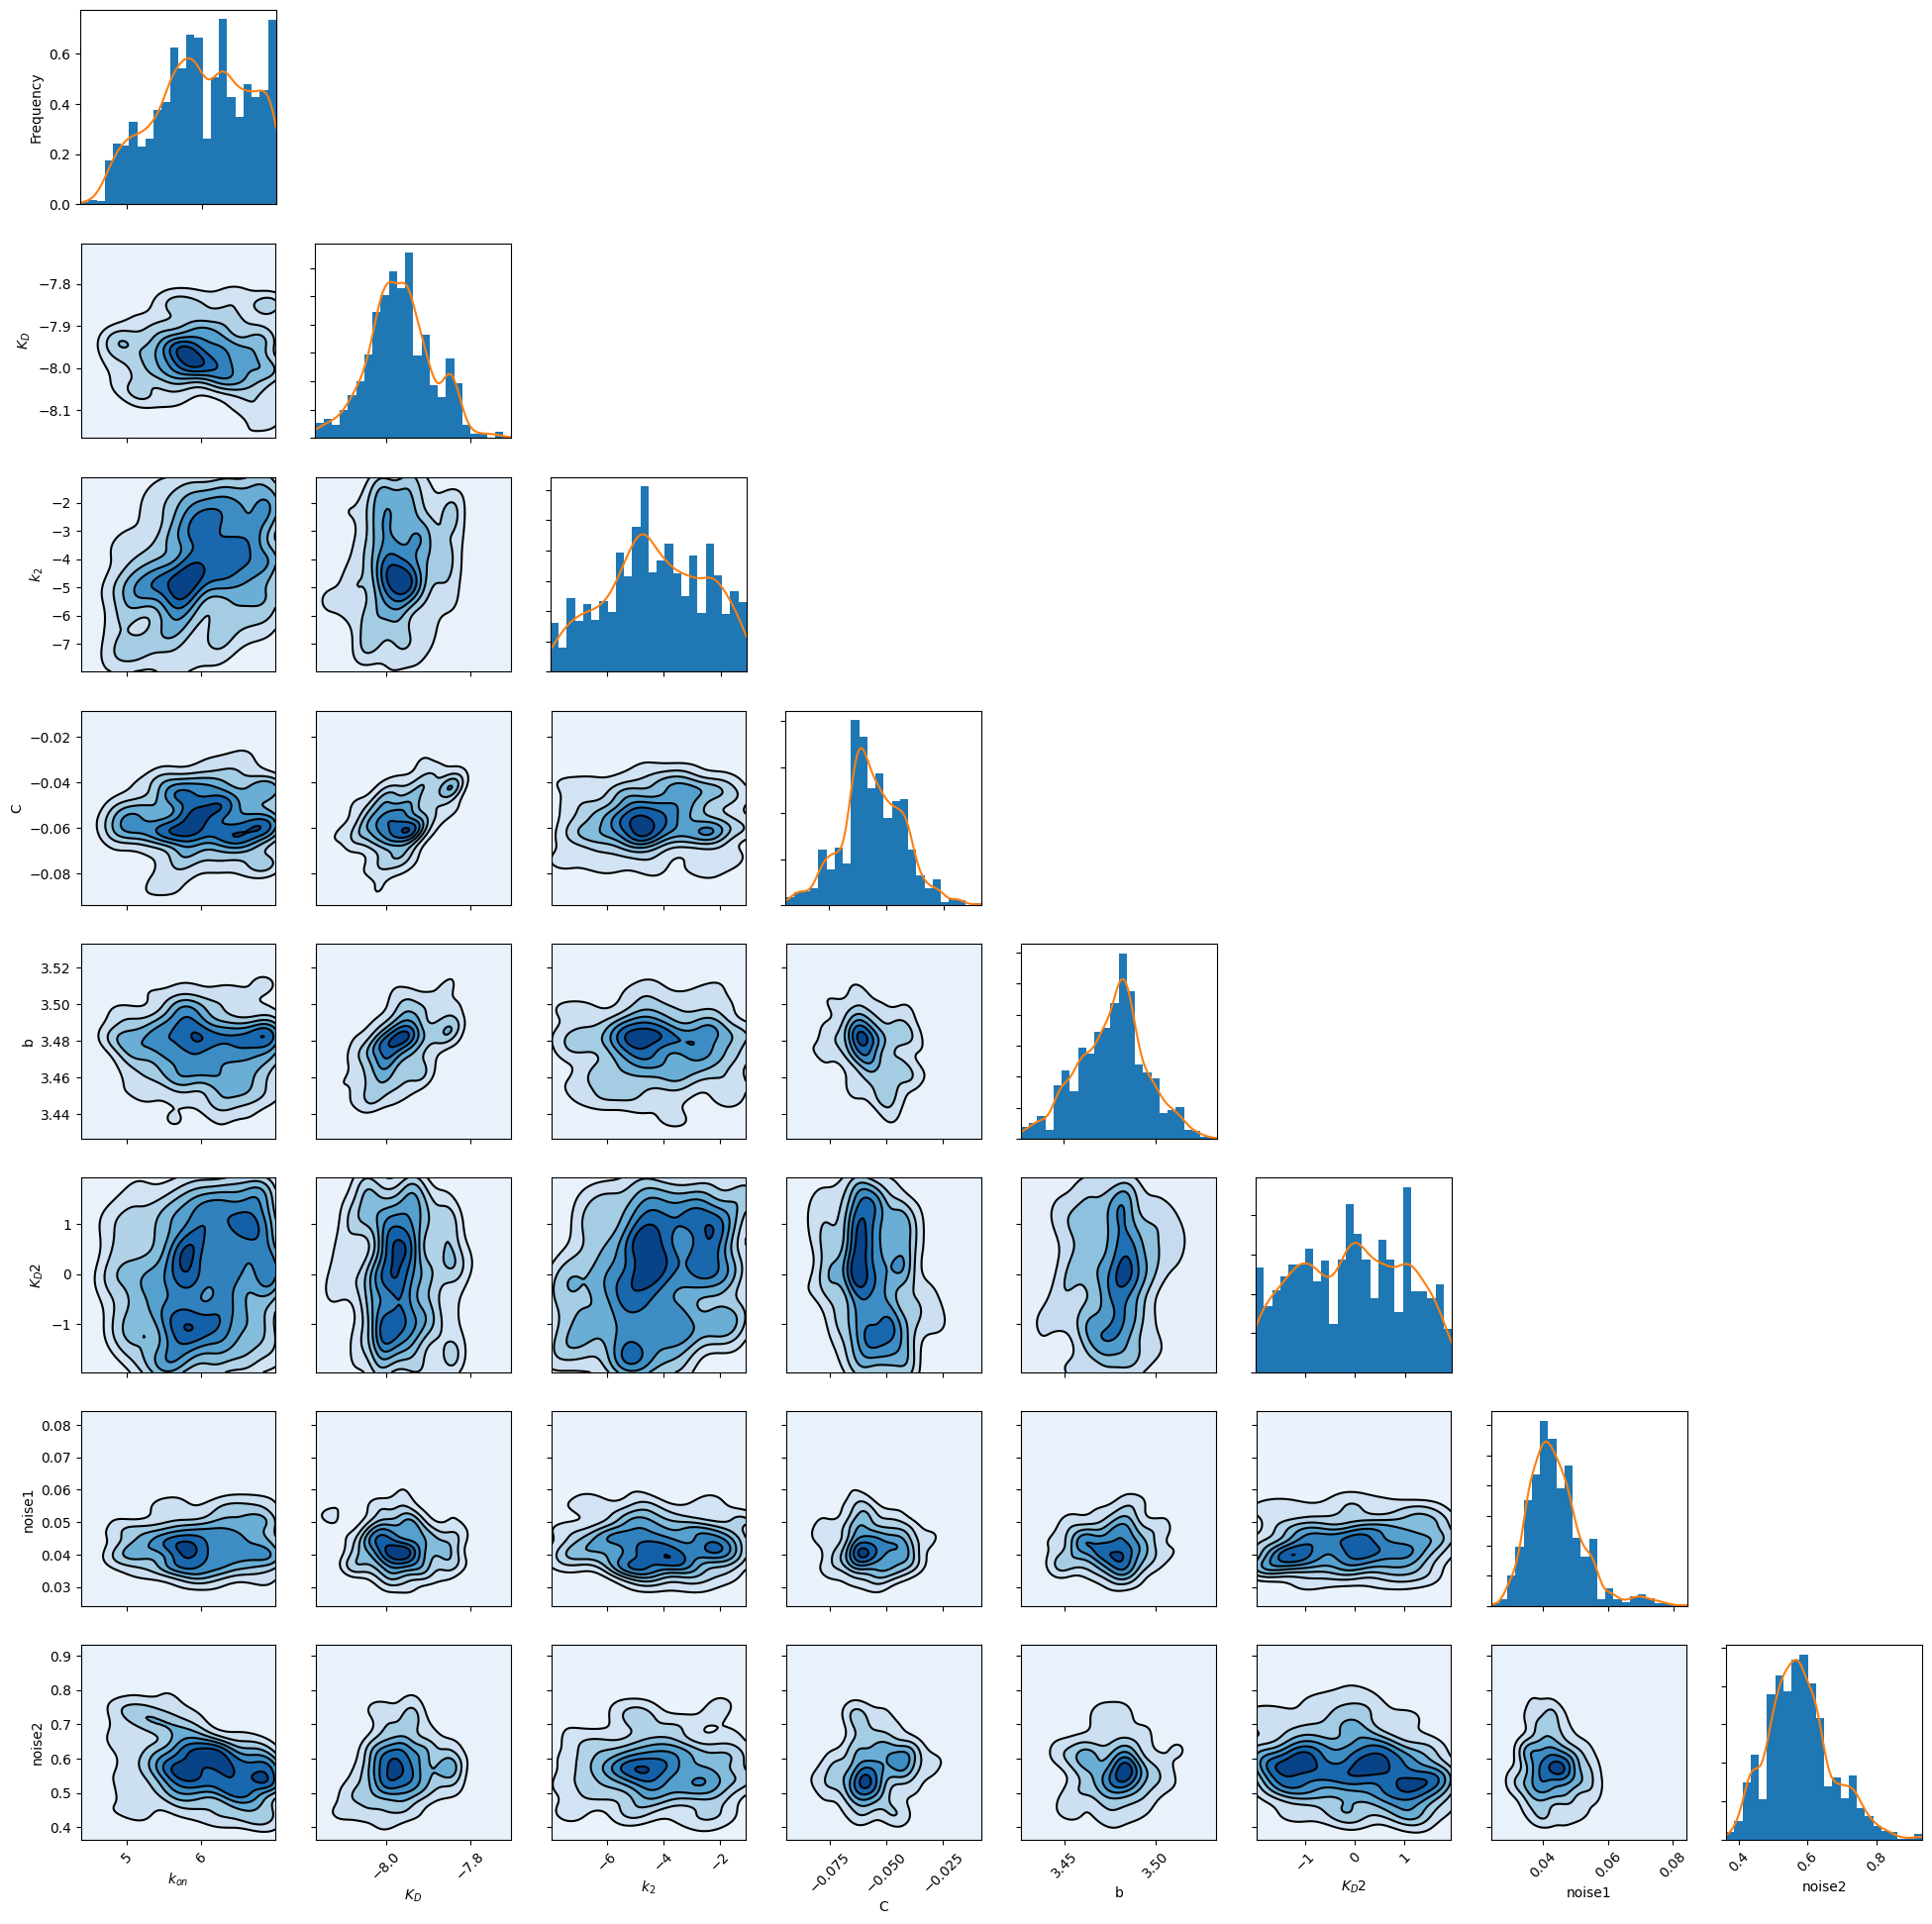

In [205]:
chain = chains[0]
chain = chain[8000:]
chains1 = chains[:, 8000 :]
pints.plot.pairwise(chain, kde=True,  parameter_names=parameter_names)
plt.show()

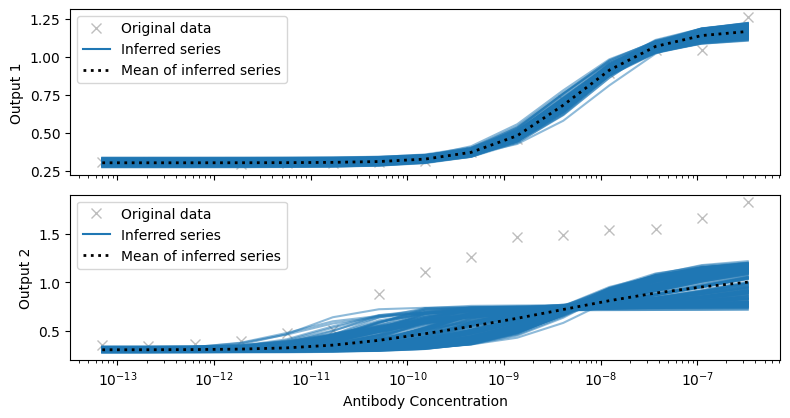

In [206]:
fig, axes = pints.plot.series(chains1[0], problem)

#fig.set_size_inches(12,4.5)
#plt.plot(A0s1, values, c='orange', label='data')
plt.legend()
plt.xscale('log')
plt.xlabel(r'Antibody Concentration')
plt.show()

In [207]:
results = pints.MCMCSummary(chains=chains1, time=mcmc.time(),parameter_names=parameter_names)
print(results)

param     mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
--------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
$k_{on}$  6.14    0.48    4.98    5.90   6.16   6.48   6.94     1.03    350.23  0.17
$K_D$     -7.07   0.90    -8.08   -7.96  -7.15  -6.16  -6.03    10.81   289.62  0.14
$k_2$     -3.09   1.91    -7.49   -4.52  -2.15  -1.61  -1.07    1.57    257.10  0.12
C         0.18    0.24    -0.08   -0.06  0.19   0.42   0.44     18.96   264.44  0.13
b         3.52    0.05    3.45    3.48   3.51   3.56   3.61     2.11    327.36  0.16
$K_D2$    -0.79   1.07    -1.96   -1.65  -1.20  -0.05  1.66     1.42    204.51  0.10
noise1    0.14    0.10    0.03    0.04   0.12   0.23   0.30     3.83    304.27  0.15
noise2    0.32    0.26    0.05    0.06   0.24   0.57   0.74     4.49    271.07  0.13


In [208]:
results_list = results._summary_list
results_dic = {}
means =[]
stds = []
l_perc = []
h_perc = []
rhats = []
parameter_names=[r'$k_{on}$', r'$K_D$', r'$k_2$', 'C','b', r'$K_D2$',]
for i, param in enumerate(parameter_names):
    holder = results_list[i]
    means.append(holder[1])
    stds.append(holder[2])
    l_perc.append(holder[3])
    h_perc.append(holder[7])
    rhats.append(holder[8])

results_dic['parameter'] = parameter_names
results_dic['mean'] = means
results_dic['std'] = stds
results_dic['2.5%'] = l_perc
results_dic['97.5%'] = h_perc
results_dic['rhat'] = rhats

[6.04690559e-02 1.81402187e-01 5.44161180e-01 1.63207477e+00
 4.89254847e+00 1.46446625e+01 4.36397760e+01 1.28340896e+02
 3.63541565e+02 9.34218438e+02 1.95947925e+03 3.08953144e+03
 3.82463840e+03 4.15406254e+03 4.27684675e+03]
[6.40275691e-01 1.92026085e+00 5.75569048e+00 1.72213503e+01
 5.12554452e+01 1.50165446e+02 4.20056016e+02 1.03190314e+03
 1.85468837e+03 2.14438068e+03 2.16703177e+03 2.18707835e+03
 2.21209798e+03 2.24944767e+03 2.30959750e+03]


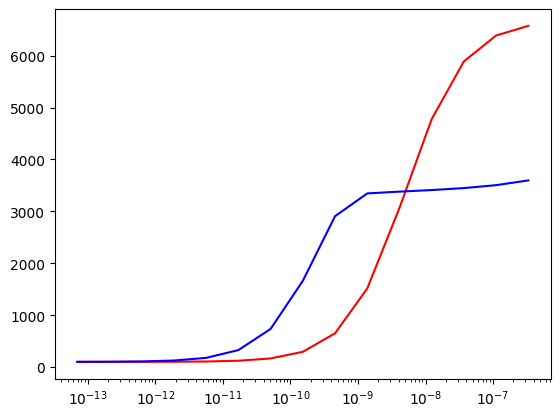

In [220]:
parameters = [5.47, -8, -2, 0.18, 2]
sim = simulate_model(conc, parameters=parameters)
plt.semilogx(conc, sim[:, 0], label='monovalent fit', c='red')
plt.semilogx(conc, sim[:, 1], label = 'bivalent fit', c='blue')
#plt.scatter(conc, data[:, 0], label='monovalent data', c='red')
#plt.scatter(conc, data[:, 1], label='bivalent data', c='blue')